# oggmap: Step 4 - other evolutionary indices

This notebook will demonstrate how to to add a other evolutionary indices to scRNA data.

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/oggmap/main/docs/notebooks/evolutionary_indices.ipynb](https://raw.githubusercontent.com/kullrich/oggmap/main/docs/notebooks/evolutionary_indices.ipynb)

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4.5]
#plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import oggmap python package submodules

In [2]:
# import submodules
from oggmap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets, ncbitax

## Step 0, Step 1, Step 2 and Step 3

In order to come to Step 4, TEI calculation, one needs to have the results from Step 0, Step 1, Step 2 and Step 3.

The query species in this part is: __*Caenorhabditis elegans*__ (nematode).

**Note:** In this tutorial Step 0 and Step 2 are different since other evolutionary indices will be used to weight gene expression. It does not need to be a gene age class but can be any discrete or continuous gene based measurement.

Other evolutionary indices can be e.g.:

- Tajima'sD
- Nucleotide diversity (within species)
- Nucleotide divergence (between species)
- F-statistics

Please have a look at the documentation of [Step 0 - run OrthoFinder](https://oggmap.readthedocs.io/en/latest/tutorials/orthofinder.html) to get to know what information and files are mandatory to extract gene age classes from [OrthoFinder](https://oggmap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results.

In [Step 1 - get taxonomic information](https://oggmap.readthedocs.io/en/latest/tutorials/query_lineage.html) you have already been introduced how to extract query lineage information with `oggmap` and the `qlin.get_qlin()` function.

In [Step 2 - gene age class assignment](https://oggmap.readthedocs.io/en/latest/tutorials/get_orthomap.html) you have already been introduced how to extract an orthomap (gene age class) from [OrthoFinder](https://oggmap.readthedocs.io/en/latest/tutorials/https://github.com/davidemms/OrthoFinder) results with `oggmap` and the `of2orthomap.get_orthomap()` function or how to import pre-calculated orthomaps with the `orthomap2tei.read_orthomap()` function.

In [Step 3 - map gene/transcript IDs](https://oggmap.readthedocs.io/en/latest/tutorials/geneset_overlap.html) you have already been introduced how to extract gene IDs from `GTF` file with `orthoamp` and the `gtf2t2g.parse_gtf()` function. You have also been introduced how to use the `orthomap2tei.geneset_overlap()` function to check the overlap between the gene IDs and have learned how to use the `orthomap2tei.replace_by()` function to e.g. reduce isoform gene IDs to gene IDs.

## Step 0 - Use different pre-calculated evolutionary indices

Diversity parameter were pre-calculated ([Ma et al., 2021](https://doi.org/10.1093/gbe/evab048)) and is available here:

[https://doi.org/10.5281/zenodo.7242263](https://doi.org/10.5281/zenodo.7242263)

or can be accessed with the `dataset` submodule of `oggmap`

`datasets.ma21_fst(datapath='data')` (download folder set to `'data'`).

In [3]:
datasets.ma21_fst(datapath='data')

100% [..........................................................................] 1049100 / 1049100

'data/Ma2021_Fst.tsv'

### Step 1 - get taxonomic information

Please have a look at the documentation of [Step 1 - get taxonomic information](https://oggmap.readthedocs.io/en/latest/tutorials/query_lineage.html) to get further insides.

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Caenorhabditis elegans', dbname='data/taxadb.sqlite')

query name: Caenorhabditis elegans
query taxID: 6239
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Protostomia(33317)', 'Ecdysozoa(1206794)', 'Nematoda(6231)', 'Chromadorea(119089)', 'Rhabditida(6236)', 'Rhabditina(2301116)', 'Rhabditomorpha(2301119)', 'Rhabditoidea(55879)', 'Rhabditidae(6243)', 'Peloderinae(55885)', 'Caenorhabditis(6237)', 'Caenorhabditis elegans(6239)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33317, 1206794, 6231, 119089, 6236, 2301116, 2301119, 55879, 6243, 55885, 6237, 6239]


## Step 2 - gene based measurement (query species evolutionary index)

Here, an other evolutionary index will be used to weight gene expression. It does not need to be a gene age class but can be any discrete or continuous gene based measurement. Continuous values can be binned first and
used as gene groups to weigh expression.

Other evolutionary indices can be e.g.:

- Tajima'sD
- Nucleotide diversity (within species)
- Nucleotide divergence (between species)
- F-statistics

In [5]:
# get query species Fst values

# download pre-calculated Fst values here: https://doi.org/10.5281/zenodo.7242263
# or download with datasets.ma21_fst(datapath='data')
query_fst = pd.read_csv('data/Ma2021_Fst.tsv', delimiter='\t')
query_fst

,WormBase_ID,Chr,Gene,TajimaD,NormalizedPi,FayWu,FST
0,WBGene00000001,I,aap-1,-0.6957,0.0002,-1.2575,0.8062
1,WBGene00000002,IV,aat-1,-0.4724,0.0001,-1.4628,0.8846
2,WBGene00000003,V,aat-2,-1.5266,0.0001,0.0816,0.1691
3,WBGene00000004,X,aat-3,-1.6401,0.0003,-4.7685,0.8129
4,WBGene00000005,IV,aat-4,-1.2137,0.0006,-0.7617,0.3725
...,...,...,...,...,...,...,...
20217,WBGene00271701,X,F10D7.10,-0.7428,0.0000,-1.9308,0.1111
20218,WBGene00271703,III,ZK1010.12,-1.3386,0.0008,-3.2528,0.7683
20219,WBGene00271706,II,D2089.8,-0.8312,0.0012,0.4489,0.5551
20220,WBGene00271707,V,ZK105.14,-1.0748,0.0004,-3.2069,0.6433


### Group evolutionary indices into bins

In [6]:
# see here for additional quantile methods: https://numpy.org/doc/stable/reference/generated/numpy.nanquantile.html

orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='TajimaD',
                      q=[.1, .2, .3, .4, .5, .6, .7, .8, .9],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='NormalizedPi',
                      q=[.2, .4, .6, .8],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='FayWu',
                      q=[.1, .2, .3, .4, .5, .6, .7, .8, .9],
                      method='median_unbiased')
orthomap2tei.get_bins(tobin_df=query_fst,
                      bincol='FST',
                      q=[.2, .4, .6, .8],
                      method='median_unbiased')

,WormBase_ID,Chr,Gene,TajimaD,NormalizedPi,FayWu,FST,TajimaD_binned,TajimaD_bins,NormalizedPi_binned,NormalizedPi_bins,FayWu_binned,FayWu_bins,FST_binned,FST_bins
0,WBGene00000001,I,aap-1,-0.6957,0.0002,-1.2575,0.8062,8.0,-0.84 >= x < -0.67368,3.0,0.0002 >= x < 0.0004,5.0,-1.68402 >= x < -0.99135,5.0,0.6286 < x
1,WBGene00000002,IV,aat-1,-0.4724,0.0001,-1.4628,0.8846,9.0,-0.67368 >= x < -0.20841999999999972,2.0,0.0001 >= x < 0.0002,5.0,-1.68402 >= x < -0.99135,5.0,0.6286 < x
2,WBGene00000003,V,aat-2,-1.5266,0.0001,0.0816,0.1691,3.0,-1.6187 >= x < -1.4602466666666667,2.0,0.0001 >= x < 0.0002,8.0,0.03219333333333343 >= x < 0.10182000000000008,3.0,0.1347 >= x < 0.3595
3,WBGene00000004,X,aat-3,-1.6401,0.0003,-4.7685,0.8129,2.0,-1.8383 >= x < -1.6187,3.0,0.0002 >= x < 0.0004,2.0,-9.455993333333332 >= x < -3.9512999999999994,5.0,0.6286 < x
4,WBGene00000005,IV,aat-4,-1.2137,0.0006,-0.7617,0.3725,5.0,-1.3196 >= x < -1.1656,4.0,0.0004 >= x < 0.0011,6.0,-0.99135 >= x < 0.0,4.0,0.3595 >= x < 0.6286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20217,WBGene00271701,X,F10D7.10,-0.7428,0.0000,-1.9308,0.1111,8.0,-0.84 >= x < -0.67368,1.0,x < 0.0001,4.0,-2.277410000000001 >= x < -1.68402,2.0,0.0 >= x < 0.1347
20218,WBGene00271703,III,ZK1010.12,-1.3386,0.0008,-3.2528,0.7683,4.0,-1.4602466666666667 >= x < -1.3196,4.0,0.0004 >= x < 0.0011,3.0,-3.9512999999999994 >= x < -2.277410000000001,5.0,0.6286 < x
20219,WBGene00271706,II,D2089.8,-0.8312,0.0012,0.4489,0.5551,8.0,-0.84 >= x < -0.67368,5.0,0.0011 < x,10.0,0.2674900000000009 < x,4.0,0.3595 >= x < 0.6286
20220,WBGene00271707,V,ZK105.14,-1.0748,0.0004,-3.2069,0.6433,6.0,-1.1656 >= x < -1.0416,4.0,0.0004 >= x < 0.0011,3.0,-3.9512999999999994 >= x < -2.277410000000001,5.0,0.6286 < x


### Gene assignments per query species evolutionary index

Given an orthomap, one can get an overview of the gene assignments per query species lineage node.

The `oggmap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

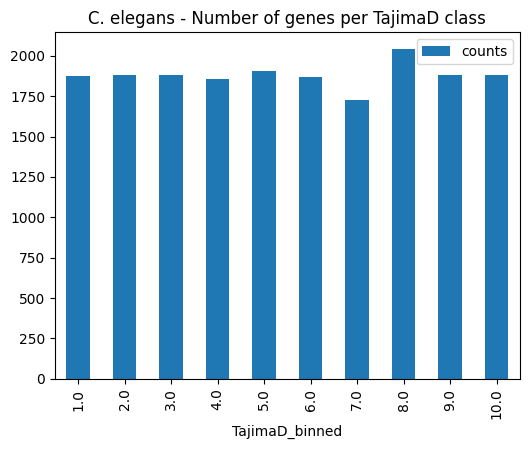

In [7]:
# show count per TajimaD group (TajimaD_binned)
of2orthomap.get_counts_per_ps(omap_df=query_fst,
    psnum_col='TajimaD_binned',
    pstaxid_col=None,
    psname_col=None)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(omap_df=query_fst,
    psnum_col='TajimaD_binned',
    pstaxid_col=None,
    psname_col=None).plot.bar(y='counts', x='TajimaD_binned')
ax.set_title('C. elegans - Number of genes per TajimaD class')
plt.show()

## Step 3 - map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `oggmap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

If in your case gene or transcript IDs between an orthomap and scRNA data do not match directly, please have a look at a detailed how-to to match them:

https://oggmap.readthedocs.io/en/latest/tutorials/geneset_overlap.html

Here, pre-calculated diversity parameter gene names already overlap, so no `GTF` import is necessary ([Ma et al., 2021](https://doi.org/10.1093/gbe/evab048)).

### Import now, the scRNA dataset of the query species

Here, data is used, like in the publication ([Packer and Zhu al., 2019](https://doi.org/10.1126/science.aax1971)).

scRNA data was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954 converted into Seurat object and converted into loom and AnnData (h5ad) files to be able to analyse with e.g. python scanpy or `oggmap` package and is available here:

https://doi.org/10.5281/zenodo.7245547

or can be accessed with the `dataset` submodule of `oggmap`:

`datasets.packer19(datapath='data')` (download folder set to `'data'`).

__Note:__ A smaller scRNA data set for the same data exist and can be obtained via:

`datasets.packer19_small(datapath='data')` (download folder set to `'data'`).

In [8]:
# load scRNA data

# download zebrafish scRNA data here: https://doi.org/10.5281/zenodo.7245547
# or download with datasets.packer19(datapath='data')

#celegans_data = datasets.packer19(datapath='data')
celegans_data = sc.read('data/GSE126954.h5ad')

### Get an overview of observations

In [9]:
celegans_data

AnnData object with n_obs × n_vars = 89701 × 20222
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted'
    var: 'features', 'genes'

In [10]:
celegans_data.obs

,orig.ident,nCount_RNA,nFeature_RNA,cell,n.umi,time.point,batch,Size_Factor,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,embryo.time,embryo.time.bin,raw.embryo.time.bin,lineage,passed_initial_QC_or_later_whitelisted
AAACCTGAGACAATAC-300.1.1,0,1630.0,781,AAACCTGAGACAATAC-300.1.1,1630,300_minutes,Waterston_300_minutes,1.023195,Body_wall_muscle,BWM_head_row_1,BWM_head_row_1,360,380.0,330-390,330-390,MSxpappp,1
AAACCTGAGGGCTCTC-300.1.1,0,2323.0,1116,AAACCTGAGGGCTCTC-300.1.1,2319,300_minutes,Waterston_300_minutes,1.458210,NA,NA,NA,260,220.0,210-270,210-270,MSxapaap,1
AAACCTGAGTGCGTGA-300.1.1,0,3725.0,1322,AAACCTGAGTGCGTGA-300.1.1,3719,300_minutes,Waterston_300_minutes,2.338283,NA,NA,NA,270,230.0,210-270,270-330,NA,1
AAACCTGAGTTGAGTA-300.1.1,0,4236.0,1747,AAACCTGAGTTGAGTA-300.1.1,4251,300_minutes,Waterston_300_minutes,2.659051,Body_wall_muscle,BWM_anterior,BWM_anterior,260,280.0,270-330,210-270,Dxap,1
AAACCTGCAAGACGTG-300.1.1,0,1003.0,621,AAACCTGCAAGACGTG-300.1.1,1003,300_minutes,Waterston_300_minutes,0.629610,Ciliated_amphid_neuron,AFD,AFD,350,350.0,330-390,330-390,ABalpppapav/ABpraaaapav,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTGAGACATGTCGAT-b02,0,581.0,361,TCTGAGACATGTCGAT-b02,585,mixed,Murray_b02,0.364709,Rectal_gland,Rectal_gland,Rectal_gland,390,700.0,> 650,390-450,NA,1
TCTGAGACATGTCTCC-b02,0,516.0,327,TCTGAGACATGTCTCC-b02,510,mixed,Murray_b02,0.323907,NA,NA,NA,510,470.0,450-510,510-580,NA,1
TGGCCAGCACGAAGCA-b02,0,843.0,543,TGGCCAGCACGAAGCA-b02,843,mixed,Murray_b02,0.529174,NA,NA,NA,400,470.0,450-510,390-450,NA,1
TGGCGCACAGGCAGTA-b02,0,634.0,397,TGGCGCACAGGCAGTA-b02,636,mixed,Murray_b02,0.397979,NA,NA,NA,330,350.0,330-390,330-390,NA,1


In [11]:
celegans_data.obs.dtypes

orig.ident                                   int32
nCount_RNA                                 float64
nFeature_RNA                                 int32
cell                                        object
n.umi                                        int32
time.point                                category
batch                                     category
Size_Factor                                float64
cell.type                                 category
cell.subtype                              category
plot.cell.type                            category
raw.embryo.time                              int32
embryo.time                                float64
embryo.time.bin                           category
raw.embryo.time.bin                       category
lineage                                   category
passed_initial_QC_or_later_whitelisted       int32
dtype: object

Prior any analysis the observations `'embryo.time.bin'` and `'batch'` will be converted into the `'category'` type. In addition a new observation `'cell.type.per.embryo.time.bin.cat'` will be created that combines sample timepoint and assigned cell type.

In [12]:
# add embryo.time.bin as category
celegans_data.obs['embryo.time.bin.cat'] = celegans_data.obs['embryo.time.bin'].astype('category')
celegans_data.obs['embryo.time.bin.cat'] = celegans_data.obs['embryo.time.bin.cat'].cat.reorder_categories(['< 100',
    '100-130','130-170','170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'])
celegans_data.obs['batch.cat'] = celegans_data.obs['batch'].astype('category')

In [13]:
celegans_data.obs['cell.type.per.embryo.time.bin.cat'] =\
    (celegans_data.obs['cell.type'].astype('string') +\
    '-' +\
    celegans_data.obs['embryo.time.bin.cat'].astype('string')).astype('category')

### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [14]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(celegans_data.var_names, query_fst['WormBase_ID'])

,g1_g2_overlap,g1_ratio,g2_ratio
0,20222,1.0,1.0


## Step 4 - Get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the gene based measurement) over all categories.

${TEI_s = \sum (e_{is} * m_i) / \sum e_{is}}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_{is}}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${m_i}$ denotes the corresponding measurement of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different categories, their gene measurement might differ based on the underlying calculation. However, both isoforms share the same gene name and their gene measurement would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene measurement to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'minimal' gene measurement.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [15]:
celegans_data.layers['counts'] = celegans_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `oggmap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

### add TajimaD, Fst and NormalizedPi to adata object

In [16]:
# add TajimaD binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['TajimaD_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='TajimaD_bin',
    add_obs=True,
    obs_name='TajimaD',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

,TajimaD
AAACCTGAGACAATAC-300.1.1,5.769133
AAACCTGAGGGCTCTC-300.1.1,5.898489
AAACCTGAGTGCGTGA-300.1.1,5.736505
AAACCTGAGTTGAGTA-300.1.1,5.795881
AAACCTGCAAGACGTG-300.1.1,5.746057
...,...
TCTGAGACATGTCGAT-b02,5.465485
TCTGAGACATGTCTCC-b02,5.543912
TGGCCAGCACGAAGCA-b02,5.524013
TGGCGCACAGGCAGTA-b02,5.652469


In [17]:
# add Fst binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['FST_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='FST_bin',
    add_obs=True,
    obs_name='Fst',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

,Fst
AAACCTGAGACAATAC-300.1.1,2.997840
AAACCTGAGGGCTCTC-300.1.1,3.103704
AAACCTGAGTGCGTGA-300.1.1,3.100244
AAACCTGAGTTGAGTA-300.1.1,3.105081
AAACCTGCAAGACGTG-300.1.1,3.011721
...,...
TCTGAGACATGTCGAT-b02,3.011302
TCTGAGACATGTCTCC-b02,3.134352
TGGCCAGCACGAAGCA-b02,3.054067
TGGCGCACAGGCAGTA-b02,3.117862


In [18]:
# add NormalizedPi binned values to existing adata object
orthomap2tei.get_tei(adata=celegans_data,
    gene_id=query_fst['WormBase_ID'],
    gene_age=query_fst['NormalizedPi_binned'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='NormalizedPi_bin',
    add_obs=True,
    obs_name='NormalizedPi',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

,NormalizedPi
AAACCTGAGACAATAC-300.1.1,2.321107
AAACCTGAGGGCTCTC-300.1.1,2.527517
AAACCTGAGTGCGTGA-300.1.1,2.445354
AAACCTGAGTTGAGTA-300.1.1,2.507382
AAACCTGCAAGACGTG-300.1.1,2.655676
...,...
TCTGAGACATGTCGAT-b02,2.267350
TCTGAGACATGTCTCC-b02,2.484896
TGGCCAGCACGAAGCA-b02,2.378922
TGGCGCACAGGCAGTA-b02,2.483049


## Step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot TajimaD class per sample timepoint

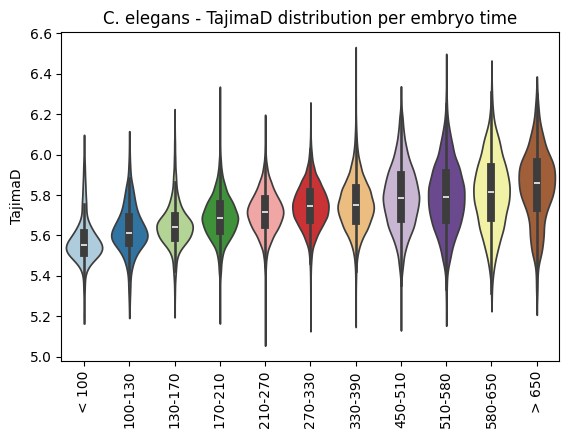

In [20]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['TajimaD'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False,
                  hue='embryo.time.bin.cat',
                  legend=False)
ax.set_title('C. elegans - TajimaD distribution per embryo time')
plt.show()

### Boxplot Fst class per sample timepoint

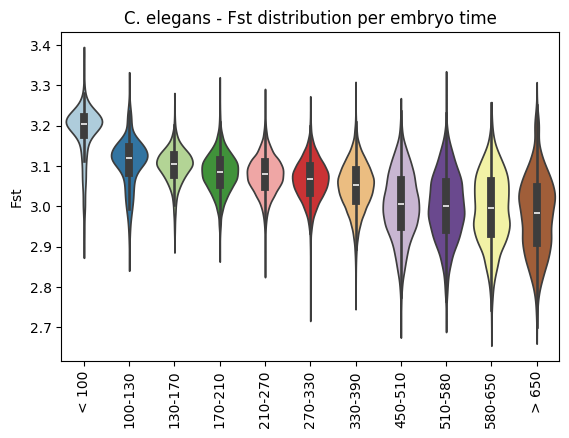

In [21]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['Fst'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False,
                  hue='embryo.time.bin.cat',
                  legend=False)
ax.set_title('C. elegans - Fst distribution per embryo time')
plt.show()

### Boxplot NormalizedPi class per sample timepoint

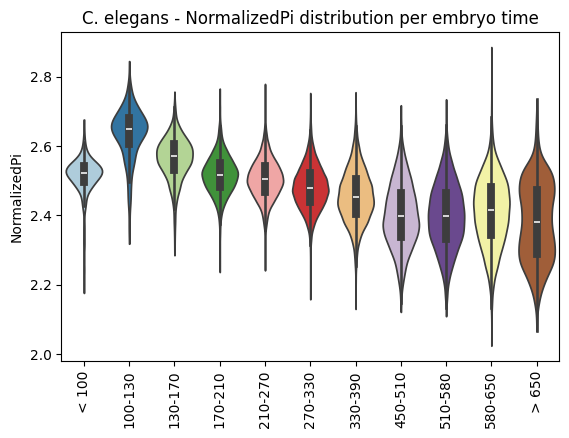

In [22]:
ax = sc.pl.violin(adata=celegans_data,
                  keys=['NormalizedPi'],
                  groupby='embryo.time.bin.cat',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  order=['< 100', '100-130', '130-170', '170-210',
                         '210-270', '270-330', '330-390', '450-510',
                         '510-580', '580-650', '> 650'],
                  show=False,
                  hue='embryo.time.bin.cat',
                  legend=False)
ax.set_title('C. elegans - NormalizedPi distribution per embryo time')
plt.show()

Please have a look at the documentation of the [nematode example](https://oggmap.readthedocs.io/en/latest/tutorials/nematode_example.html) to see more downstream analysis e.g. how to compare gene age and other evolutionary indices of the same scRNA data or have a look at the documentation for other [case studies](https://oggmap.readthedocs.io/en/latest/tutorials/index.html#case-studies).